# Run Notes 
V10 (run v1- load local run local run). 


Steps 
1. Feature Engineering:
    - Implemented custom encoding techniques to meaningfully represent the unique aspects of our dataset.
    - Replaced special codes with missing values, standardizing the dataset for more effective analysis.
    - Created dummy variables for missing values, interpreting them as indicative of medical conditions or features, to enrich our dataset's informational value.
    - Imputation of Missing Values, NICE algorithm for sophisticated imputation, aiming to address and mitigate the impact of missing data comprehensively.
3. Optimized Catboost:
    - Utilized Catboost, optimized through Optuna with a focus on the RMSEWithUncertainty loss function. This optimization was essential for calibrating interval values effectively, drawing upon the principles of the Minimum Weight Independent Set (MWIS) to refine our predictions

Calibration of Prediction Intervals:

The calibration process normalizing absolute prediction errors against the predicted uncertainty (standard deviation) and sorting these scores in reverse order, we dynamically adjust our intervals. This approach allows us to refine the intervals based on the relative accuracy of our uncertainty estimates, a method inspired by the technique detailed in [Conformalized Catboost Uncertainty without Hyperopt](https://www.kaggle.com/code/jefjai/conformalized-catboost-uncertainty-w-o-hyperopt) by Jef Jonkers on Kaggle. This calibration ensures our prediction intervals are both accurate and reflective of the underlying model's certainty, thereby enhancing the reliability of our predictions.

* lack of feature selection(todo)
* notebook run with config parameters loading data take time. 

# Libraries

In [1]:
import socket
import sys
import os

import warnings
import numpy as np
import pandas as pd

from scipy.stats import t
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import KFold

from catboost import Pool, CatBoostRegressor
from lightgbm import LGBMRegressor

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice
from optuna.pruners import MedianPruner

import shap
#from mapie.regression import MapieQuantileRegressor, MapieRegressor

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
Computer_Name = socket.gethostname()
print('Computer Name:' +  socket.gethostname())
print('Python Version:' + sys.version)

# Set up the paths for local and kaggle
if Computer_Name in ['MSI', 'HOME']:
    # Paths for local environment
    train_path = 'https://filedn.com/lK8J7mCaIwsQFcheqaDLG5z/data/Kaggle-interval-birth/train.csv'
    test_path = 'https://filedn.com/lK8J7mCaIwsQFcheqaDLG5z/data/Kaggle-interval-birth/train.csv'
    submission_path = 'https://filedn.com/lK8J7mCaIwsQFcheqaDLG5z/data/Kaggle-interval-birth/sample_submission.csv'
    environment = 'local' 
else:
    # Paths for Kaggle environment
    train_path = '/kaggle/input/prediction-interval-competition-i-birth-weight/train.csv'
    test_path = '/kaggle/input/prediction-interval-competition-i-birth-weight/test.csv'
    submission_path = '/kaggle/input/prediction-interval-competition-i-birth-weight/sample_submission.csv'
    environment = 'Kaggle'  
    
print(environment)

Computer Name:HOME
Python Version:3.11.8 | packaged by Anaconda, Inc. | (main, Feb 26 2024, 21:34:05) [MSC v.1916 64 bit (AMD64)]
local


In [3]:
if environment == 'Kaggle':
    sys.path.append('/kaggle/input/birth-set-processed-1/')
    imputed_train_path = os.path.join('/kaggle/input/birth-set-processed-1', 'imputed_train1.pkl')
    imputed_test_path = os.path.join('/kaggle/input/birth-set-processed-1', 'imputed_test1.pkl')
    
else:
    imputed_train_path = os.path.join('./output', 'imputed_train1.pkl')
    imputed_test_path = os.path.join('./output', 'imputed_test1.pkl')

In [4]:
if environment == 'Kaggle':
    sys.path.append('/kaggle/input/winkler-interval-score-metric/')
else:
    sys.path.append('./src')

from  feature_engineering import data_pre_process, calculate_pregnancy_length
import MWIS_metric

# Functions

In [5]:
def simplified_fit_impute(train_data, test_data=None, skipCols=None):
    """
    Apply the imputation of missing data using the MICE algorithm to both training and test data.
    
    Args:
        train_data (pd.DataFrame): The training DataFrame with missing values.
        test_data (pd.DataFrame, optional): The test DataFrame with missing values. Default is None.
        skipCols (list, optional): List of column names to be excluded from imputation.

    Returns:
        pd.DataFrame, pd.DataFrame: The imputed training DataFrame, and the imputed test DataFrame if test_data is provided, preserving the original indexes.
    """
    train_data_copy = train_data.copy()
    original_train_index = train_data_copy.index  # Store the original index for the training data

    if test_data is not None:
        test_data_copy = test_data.copy()
        original_test_index = test_data_copy.index  # Store the original index for the test data

    # Remove specified columns from both datasets
    if skipCols is not None:
        train_data_copy.drop(columns=skipCols, inplace=True)
        if test_data is not None:
            test_data_copy.drop(columns=skipCols, inplace=True)
    
    # Initialize the imputer with specified maximum iterations and random state
    imputer = IterativeImputer(max_iter=10, random_state=0)
    
    # Fit the imputer on the training data and transform it
    imputer.fit(train_data_copy)
    imputed_train_data = imputer.transform(train_data_copy)
    imputed_train_df = pd.DataFrame(imputed_train_data, columns=train_data_copy.columns, index=original_train_index)

    imputed_test_df = None
    if test_data is not None:
        # Transform the test data using the fitted imputer
        imputed_test_data = imputer.transform(test_data_copy)
        imputed_test_df = pd.DataFrame(imputed_test_data, columns=test_data_copy.columns, index=original_test_index)
    
    return imputed_train_df, imputed_test_df

## Parameters

In [6]:
# Configuration variables
LOAD_IMPUTE = 'load'   # Options: 'load', None
LOAD_OPTUNA = 'load'     # Options: 'load', None
LOAD_FEATURE_SELECTOR = None  # Options: 'load', None

# Additional settings
test_size = 0.10
#cal_size = 0.05
random_state = 42
alpha = 0.10
rng = np.random.default_rng(random_state)

In [7]:
# Print the current configuration settings
print("Configuration Settings:")
print(f"LOAD_IMPUTE: {LOAD_IMPUTE}")
print(f"LOAD_OPTUNA: {LOAD_OPTUNA}")
print(f"LOAD_FEATURE_SELECTOR: {LOAD_FEATURE_SELECTOR}")

# Conditional execution based on the configuration
if LOAD_IMPUTE is None:
    print("Running Imputation...")
else:
    print("Loading Imputed Data...")

if LOAD_OPTUNA is None:
    print("Running Optuna Optimization...")
else:
    print("Loading Optuna Results...")

if LOAD_FEATURE_SELECTOR is None:
    print(" Doesnt Selecting Features...")
else:
    print("Loading Selected Features...")

Configuration Settings:
LOAD_IMPUTE: load
LOAD_OPTUNA: load
LOAD_FEATURE_SELECTOR: None
Loading Imputed Data...
Loading Optuna Results...
 Doesnt Selecting Features...


## Load Data

In [8]:
train = pd.read_csv(train_path, index_col="id")
test = pd.read_csv(test_path, index_col="id")

# Feature engineering

In [9]:
train = calculate_pregnancy_length(train)
test = calculate_pregnancy_length(test)

In [10]:
train_processed, var_list_train = data_pre_process(train)
test_processed, var_list_test = data_pre_process(test)

In [11]:
# diff1 = set(train_processed.columns) - set(test_processed.columns)
# diff2 = set(test_processed.columns) - set(train_processed.columns)
# print('set differences:', diff1, diff1)

In [12]:
columns_to_drop = ['BFACIL_Unknown', 'RDMETH_REC_Unknown', 'ATTEND_Other', 'MBSTATE_REC_born_not_in_US']
# train_processed = train_processed.drop(columns_to_drop) # didnt work
train_processed = train_processed[[col for col in train_processed.columns if col not in columns_to_drop]]
test_processed = test_processed[[col for col in test_processed.columns if col not in columns_to_drop]]

In [13]:
# split features and target
X = train_processed.drop("DBWT", axis=1)
y = train_processed["DBWT"]

In [14]:
# inpute missing values , we show NICE works better than Trees
if LOAD_IMPUTE is None:
    print("Running Imputation...")
    X , test_processed = simplified_fit_impute(X,test_processed)
else:
    print("Load Imputation...")
    X = pd.read_pickle(imputed_train_path)
    y =train["DBWT"]
    test_processed= pd.read_pickle(imputed_test_path)

Load Imputation...


# Sampling 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

In [16]:
if LOAD_FEATURE_SELECTOR: 
    feature_selector = ['DOB_MM', 'DOB_WK', 'NO_RISKS', 'MAGER', 'PREG_LEN', 'DOB_TT', 'ATTEND_Certified_Nurse_Midwife', 'ATTEND_Doctor_of_Medicine', 'ATTEND_Doctor_of_Osteopathy', 'ATTEND_Other_Midwife', 'ATTEND_Unknown_or_not_stated', 'BFACIL_Clinic', 'BFACIL_Doctor_Office', 'BFACIL_Freestanding_Birth_Center', 'BFACIL_Home_intended', 'BFACIL_Home_notintended', 'BFACIL_Home_unknown', 'BFACIL_Hospital', 'FEDUC_8th_grade_or_less', 'FEDUC_9to12th_grade', 'FEDUC_Associate_degree', 'FEDUC_Bachelor_degree', 'FEDUC_Doctorate', 'FEDUC_High_School_graduate', 'FEDUC_Master_degree', 'FEDUC_Unknown', 'MBSTATE_REC_Unknown', 'MBSTATE_REC_born_in_US', 'MEDUC_8th_grade_or_less', 'MEDUC_Associate_degree', 'MEDUC_Bachelor_degree', 'MEDUC_Master_degree', 'MEDUC_Some_college_credit', 'MEDUC_Unknown', 'RDMETH_REC_Primary_Csection', 'RDMETH_REC_Repeat_Csection', 'RDMETH_REC_Vaginal', 'RDMETH_REC_Vaginal_after_previous_Csection', 'RESTATUS_Foreign_resident', 'RESTATUS_Interstate_nonresident', 'RESTATUS_Intrastate_nonresident', 'RESTATUS_Resident', 'CIG_0_Notsmoker', 'CIG_0_1to10', 'CIG_0_10to20', 'CIG_0_More20', 'CIG_0_Unknown', 'LD_INDL', 'SEX', 'DMAR_Married', 'DMAR_Unknown', 'DMAR_Unmarried', 'BMI_missing', 'BMI', 'DLMP_MM_missing', 'DLMP_MM', 'ILLB_R_unknown', 'ILLB_R_notapplicated', 'ILLB_R', 'ILOP_R_unknown', 'ILOP_R_notapplicated', 'ILOP_R', 'ILP_R_unknown', 'ILP_R', 'M_Ht_In_unknown', 'M_Ht_In', 'PRECARE_unknown', 'PRECARE', 'PREVIS_unknown', 'PREVIS', 'PRIORDEAD', 'PRIORLIVE_unknown', 'PRIORLIVE', 'PRIORTERM_unknown', 'PRIORTERM', 'PWgt_R_unknown', 'RF_CESARN_unknown', 'RF_CESARN', 'WTGAIN_unknown', 'WTGAIN']
    X_train = X_train[feature_selector]
    X_test = X_test[feature_selector]
    print("Loaded Selected Features")
else:
    print("Selected Features skipped")

Selected Features skipped


In [17]:
# fake for calib. todo later
X_calib = X_test
y_calib = y_test
print("set fake calid/test - todo")

set fake calid/test - todo


# Optuna 

In [18]:
def objective(trial):
    
    params = {
        'iterations': trial.suggest_int('iterations', 50, 3000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 1, 20),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 30.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
        'od_wait': trial.suggest_int('od_wait', 10, 50),
    }
    
    params.update({
        'loss_function': 'RMSEWithUncertainty',
        'eval_metric': 'RMSEWithUncertainty',
        'boosting_type': 'Plain',
        'bootstrap_type': 'Bernoulli',
        'od_type': 'Iter', 
        'random_seed': random_state,  
        'verbose': 0
    })
    
    
    # K-Fold Cross Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    mwis_scores = []
    
    id_values = X.index.values

    for train_index, test_index in kf.split(X):
        # Convert positional indices to 'id' values
        train_ids = id_values[train_index]
        test_ids = id_values[test_index]
    
        # select rows based on 'id' values
        X_train, X_test = X.loc[train_ids], X.loc[test_ids]
        y_train, y_test = y.loc[train_ids], y.loc[test_ids]
        
        # Initialize CatBoost with parameters
        model = CatBoostRegressor(**params)
        train_pool = Pool(X_train, y_train)
        eval_pool = Pool(X_test, y_test)
        
        try:
            model.fit(train_pool, eval_set=eval_pool, early_stopping_rounds=100, verbose=0)
            pred_cal = model.predict(X_test)  
            
            # Calculate calibration scores and intervals
            cal_scores_norm = np.sort(np.abs(y_test - pred_cal[:, 0]) / np.sqrt(pred_cal[:, 1]))[::-1]
            cal_int_norm = pred_cal[:, 0].reshape(-1, 1) + np.array([[-1, 1]]) * (cal_scores_norm[int(np.floor(len(cal_scores_norm) * 0.1))] * np.sqrt(pred_cal[:, 1])).reshape(-1, 1)
            
            # MWIS calculation        
            MWIS, coverage = MWIS_metric.score(y_test, cal_int_norm[:, 0], cal_int_norm[:, 1], 0.1)
            mwis_scores.append(MWIS)
            
        except Exception as e:
            print(f"An error occurred: {e}")
            continue  # Skip to the next fold if an error occurs

    # Average MWIS score across all folds
    avg_mwis = np.mean(mwis_scores)
    
    # For pruning
    trial.report(avg_mwis, trial.number)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
        
    return avg_mwis

In [19]:
if LOAD_OPTUNA is None:
    print("Running Optuna Optimization...")
    study = optuna.create_study(study_name=f'catboost_Unc-seed{random_state}', direction='minimize', pruner=MedianPruner()) 
    # Perform the optimization
    study.optimize(objective, n_trials=100, n_jobs=-1)
    # Best hyperparameters
    best_params = study.best_params
else:
    print("Loading Optuna Results...")

Loading Optuna Results...


In [20]:
if LOAD_OPTUNA is None:
    plot_optimization_history(study)

In [21]:
if LOAD_OPTUNA is None:
    print(study.best_params)

In [22]:
if LOAD_OPTUNA is None:
    best_hyperparams = study.best_params
    # Manually include static parameters in the best_hyperparams dictionary
    best_hyperparams.update({
        'loss_function': 'RMSEWithUncertainty',
        'boosting_type': 'Plain',
        'bootstrap_type': 'Bernoulli',
        'od_type': 'Iter', 
        'random_seed': random_state,  
        'verbose': 0
    })
    print(best_hyperparams)
else:
    # COPY PASTE 
    # optimise WMI local 
    # best_hyperparams ={'iterations': 2511, 'learning_rate': 0.03140597314873103, 'depth': 5, 'l2_leaf_reg': 9.213809119157029, 'loss_function': 'RMSEWithUncertainty', 'border_count': 118, 'leaf_estimation_method': 'Newton', 'random_seed': 42, 'verbose': 0, 'random_strength': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6568660733788696, 'grow_policy': 'SymmetricTree'}
    #v1
    best_hyperparams = {'iterations': 1799, 'learning_rate': 0.06081992833236827, 'depth': 4, 'l2_leaf_reg': 8.523662897390336, 'loss_function': 'RMSEWithUncertainty', 'border_count': 174, 'leaf_estimation_method': 'Newton', 'random_seed': 42, 'verbose': 0, 'random_strength': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7311220069090056, 'grow_policy': 'SymmetricTree'}

In [23]:
if LOAD_OPTUNA is None:
    print("Optuna optimasation Finished")
else:
    print("Parameters manually Loaded")

Parameters manually Loaded


# Train final model 

In [24]:
model = CatBoostRegressor(**best_hyperparams)
print(model.get_params())

{'iterations': 1799, 'learning_rate': 0.06081992833236827, 'depth': 4, 'l2_leaf_reg': 8.523662897390336, 'loss_function': 'RMSEWithUncertainty', 'border_count': 174, 'leaf_estimation_method': 'Newton', 'random_seed': 42, 'verbose': 0, 'random_strength': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7311220069090056, 'grow_policy': 'SymmetricTree'}


In [25]:
model.fit(X_train, y_train)

In [50]:
#import pickle
# Save the model to a file
# with open('./output/model.pkl', 'wb') as file:
#    pickle.dump(model, file)

# Explain final model

In [26]:
feature_importance = model.feature_importances_
feature_names =  X_train.columns.to_numpy()

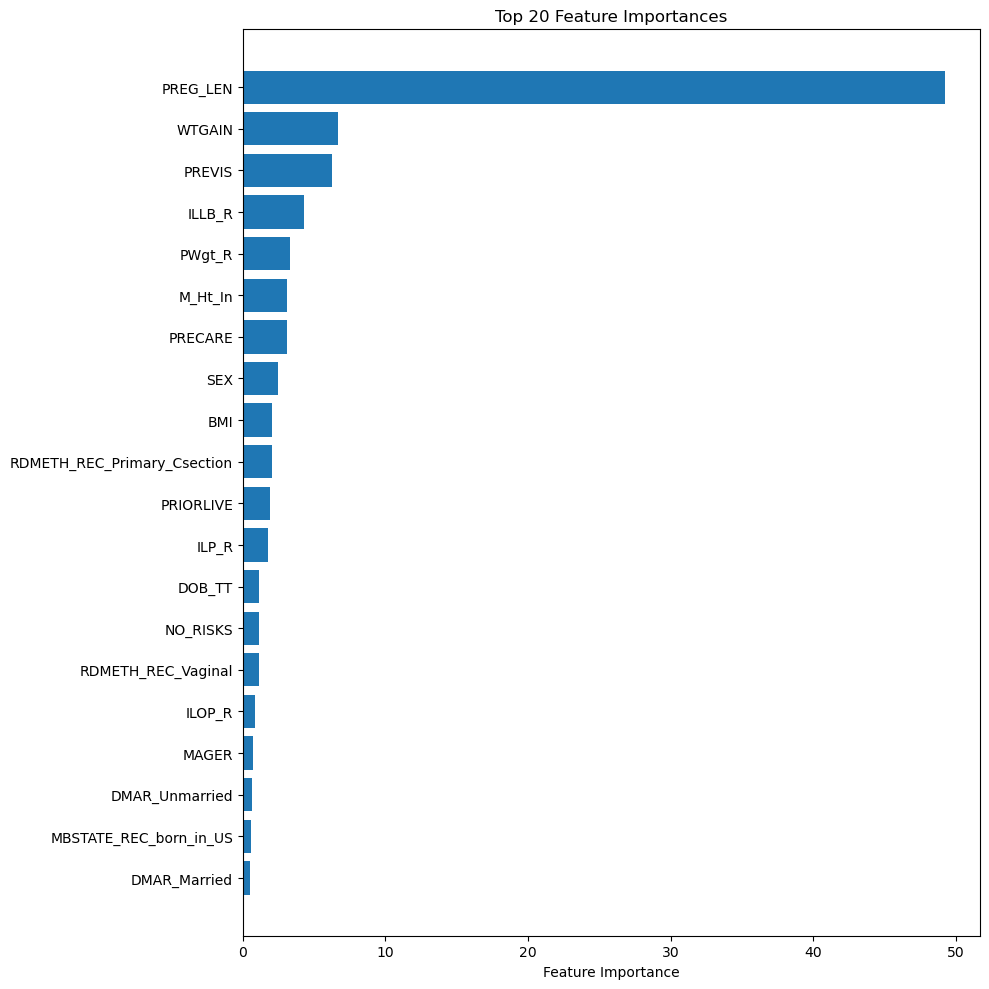

In [27]:
sorted_idx = np.argsort(feature_importance)[-20:]

# Create the plot for only the top 20 features
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(range(20), feature_importance[sorted_idx], align='center')
ax.set_yticks(range(20))
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_xlabel('Feature Importance')
ax.set_title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

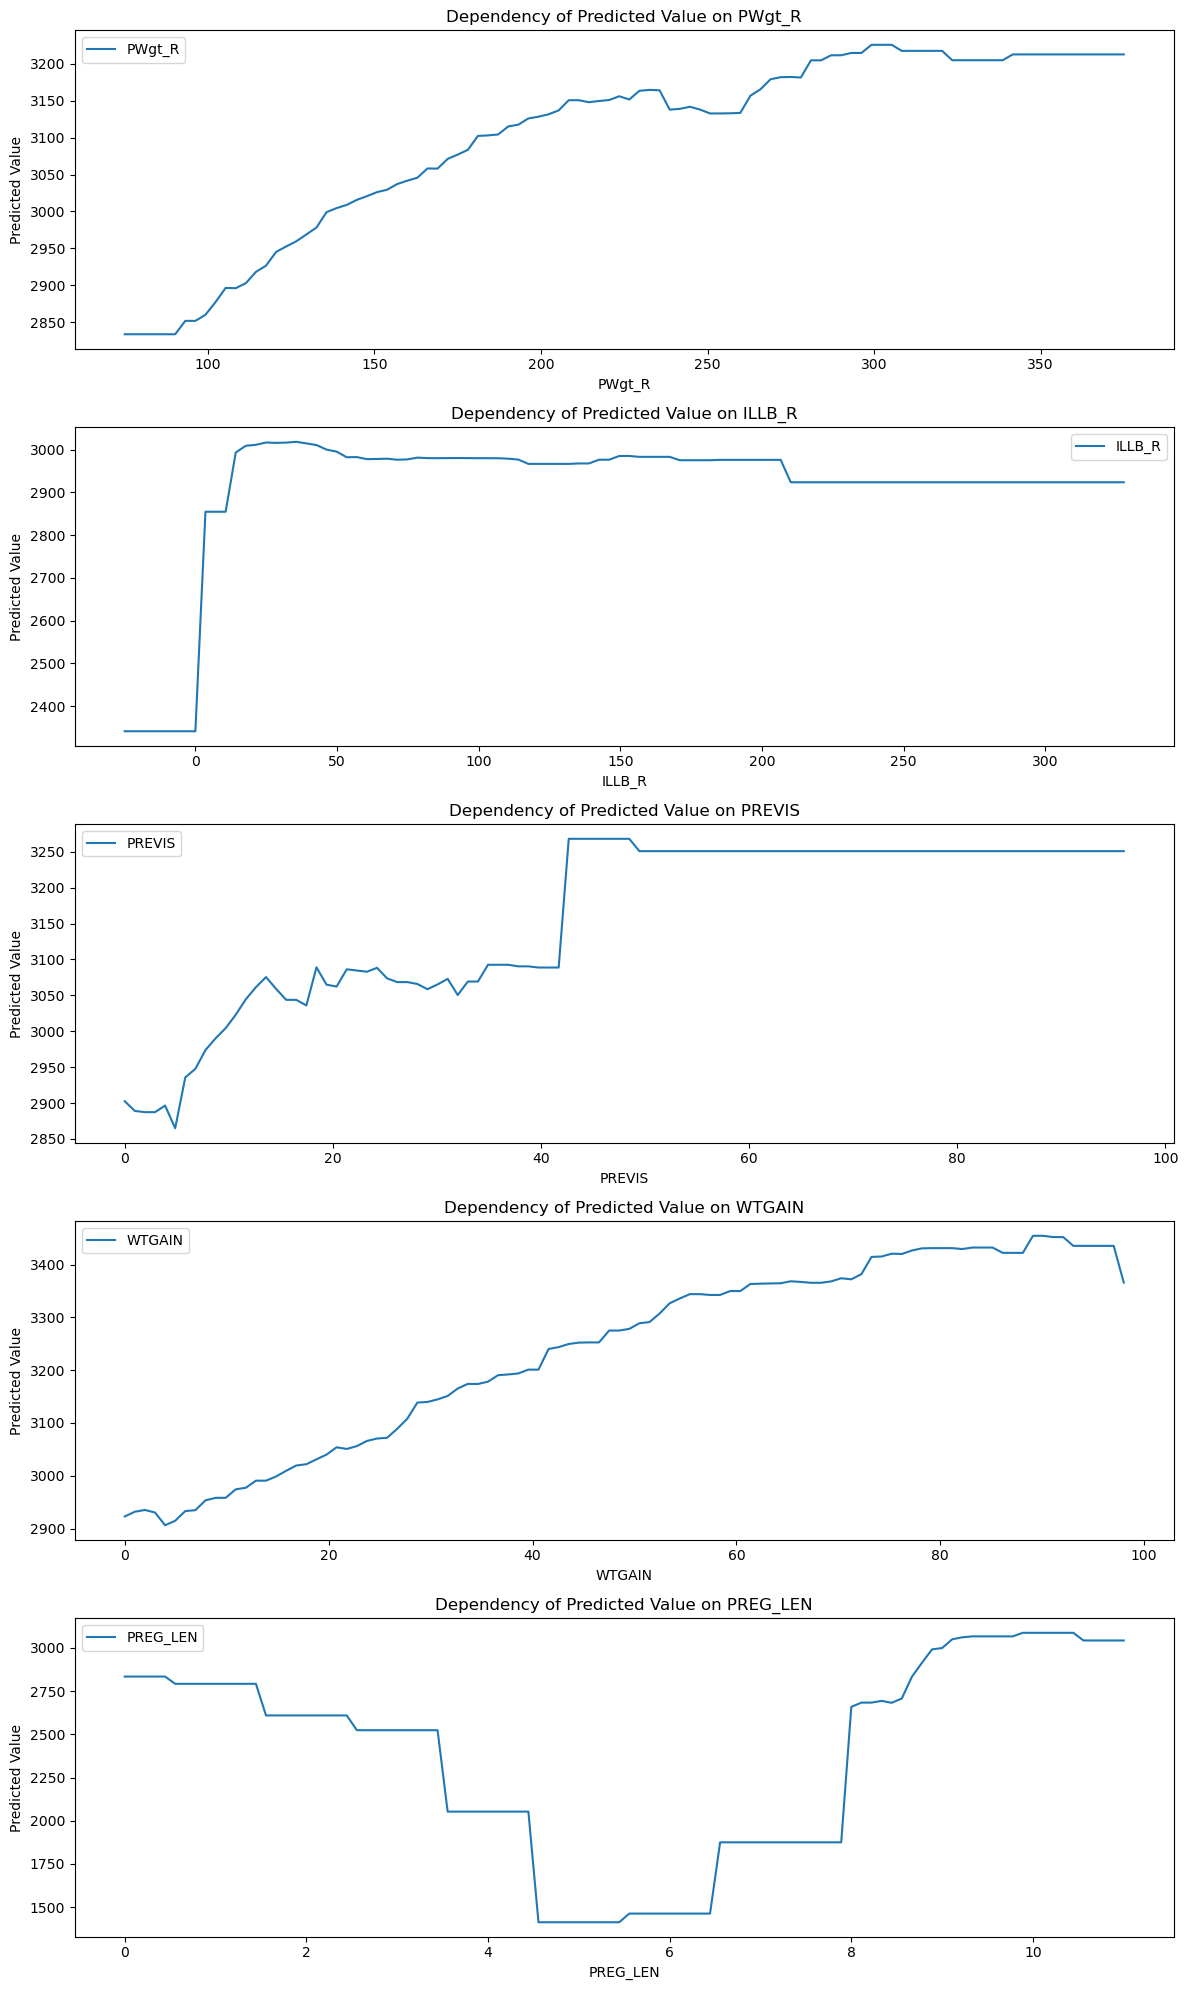

In [28]:
# Select the indices of the top 5 features
top_5_features_idx = np.argsort(feature_importance)[-5:]


# Get the names
features = np.array(X_train.columns)[top_5_features_idx]

plt.figure(figsize=(12, 20))

# Loop over the top 5 features
for i, feature_name in enumerate(features):  # Directly use feature_name

    # Generate a range of values for this feature
    feature_range = np.linspace(X_train[feature_name].min(), X_train[feature_name].max(), 100)

    # Initialize a list to store the predictions
    mean_predictions = []

    # For each value in the range
    for value in feature_range:
        # Create a copy of the dataset where this feature is set to the current value
        # and all other features are set to their median values
        X_temp = X_train.copy()
        X_temp[feature_name] = value
        
        # Predict using the model and extract only the first element of the prediction
        pred = model.predict(X_temp)
        mean_predictions.append(pred[0][0])  # Append only the first element of the prediction

    # Plotting the dependency for the current feature
    plt.subplot(5, 1, i+1)
    plt.plot(feature_range, mean_predictions, label=feature_name)
    plt.xlabel(feature_name)
    plt.ylabel('Predicted Value')
    plt.title(f'Dependency of Predicted Value on {feature_name}')
    plt.legend()

plt.tight_layout()
plt.show()

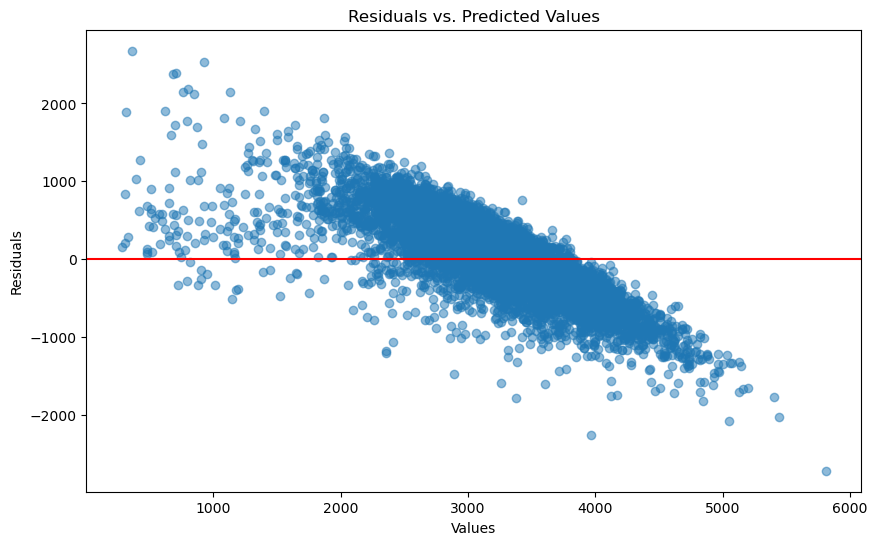

In [29]:
predictions = model.predict(X_test)
mean_predictions = predictions[:, 0]
residuals =  mean_predictions - y_test


plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

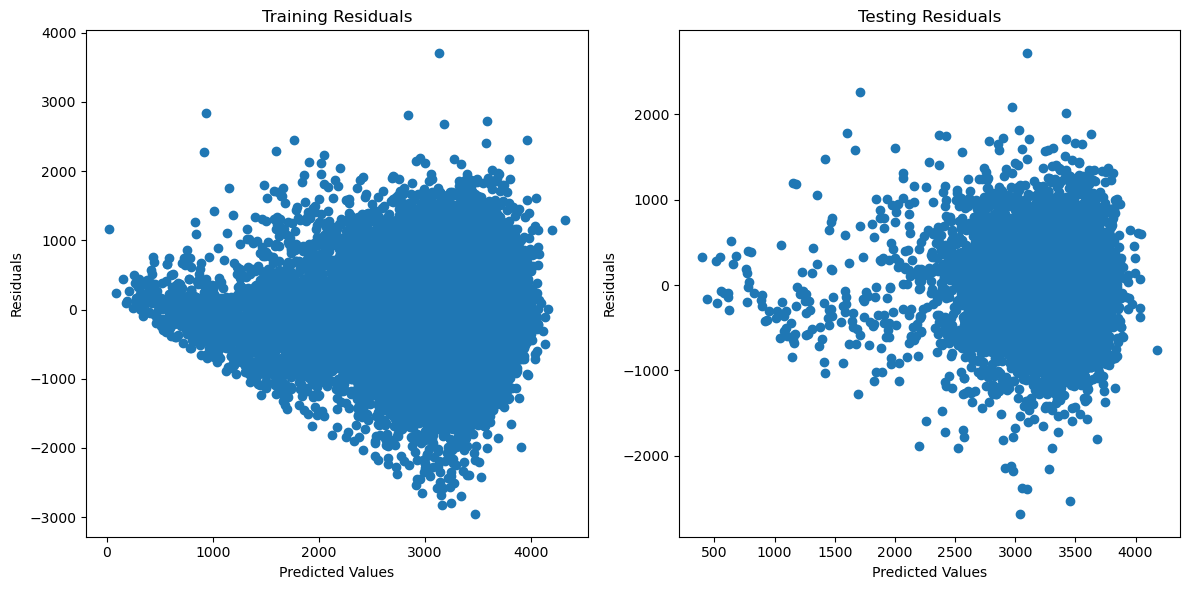

In [30]:
# Predict on training and testing sets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_predictions= train_predictions[:, 0]
test_predictions = test_predictions[:, 0]

# Calculate residuals
train_residuals = y_train - train_predictions
test_residuals = y_test - test_predictions

# Compare residuals
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(train_predictions, train_residuals)
plt.title('Training Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.scatter(test_predictions, test_residuals)
plt.title('Testing Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

In [31]:
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Create a DataFrame to display the errors
error_metrics = pd.DataFrame({
    "Metric": ["Mean Squared Error", "Mean Absolute Error", "R^2 Score"],
    "Train": [train_mse, train_mae, train_r2],
    "Test": [test_mse, test_mae, test_r2]
})

print(error_metrics)

                Metric          Train           Test
0   Mean Squared Error  202010.258310  210800.584100
1  Mean Absolute Error     346.757990     354.189770
2            R^2 Score       0.419987       0.381936


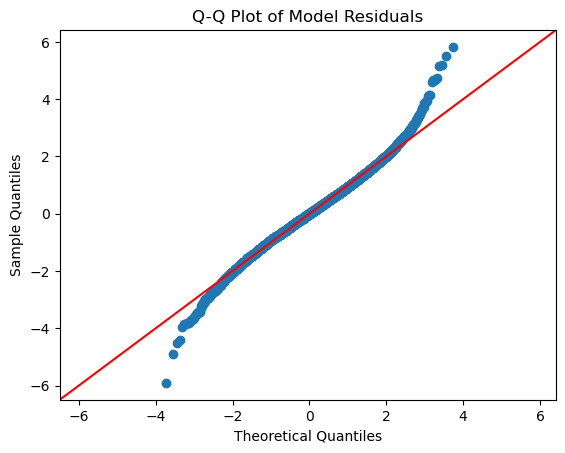

In [32]:
residuals = np.array(residuals)
sm.qqplot(residuals, line ='45', fit=True)
plt.title('Q-Q Plot of Model Residuals')
plt.show()

# Calibrate 

idea use from https://www.kaggle.com/jefjai

https://www.kaggle.com/code/jefjai/conformalized-catboost-uncertainty-w-o-hyperopt



In [33]:
X_cal=X_test
y_cal=y_test


alpha = 0.1

# Degrees of freedom for the t-distribution
n = len(y_cal)
df = n - 1
# Calculate the t-score for the given confidence level and degrees of freedom
t_score = t.ppf(1 - alpha/2, df)


pred_cal = model.predict(X_cal)

cal_scores_norm = np.sort(np.abs((y_cal.to_numpy() - pred_cal[:, 0])) / np.sqrt(pred_cal[:, 1]))[::-1]
cal_scores = np.sort(np.abs((y_cal.to_numpy() - pred_cal[:, 0])))[::-1]

In [34]:
cal_int_norm = pred_cal[:, 0].reshape(-1, 1) + np.array([[-1, 1]]) * (cal_scores_norm[int(np.floor(len(cal_scores_norm)*alpha))] * np.sqrt(pred_cal[:, 1])).reshape(-1, 1)
print("Winkler Interval score (norm cp): ", MWIS_metric.score(y_cal.to_numpy(), cal_int_norm[:, 0], cal_int_norm[:, 1], 0.1))

cal_int_t_dist = pred_cal[:, 0].reshape(-1, 1) + np.array([[-1, 1]]) * t_score * np.sqrt(pred_cal[:, 1]).reshape(-1, 1)
print("Winkler Interval score (t-distcribution cp): ", MWIS_metric.score(y_cal.to_numpy(), cal_int_t_dist[:, 0], cal_int_t_dist[:, 1], 0.1))

cal_int_normal_dist = pred_cal[:, 0].reshape(-1, 1) + np.array([[-1, 1]]) * 1.64 * np.sqrt(pred_cal[:, 1].reshape(-1, 1))
print("Winkler Interval score (assume normal error dist): ", MWIS_metric.score(y_cal.to_numpy(), cal_int_normal_dist[:, 0], cal_int_normal_dist[:, 1], 0.1))

cal_int = pred_cal[:, 0].reshape(-1, 1) + np.array([[-1, 1]]) * cal_scores[int(np.floor(len(cal_scores)*alpha))].reshape(-1, 1)
print("Winkler Interval score (cp): ", MWIS_metric.score(y_cal.to_numpy(), cal_int[:, 0], cal_int[:, 1], 0.1))

Winkler Interval score (norm cp):  (1904.26486373622, 0.9000832639467111)
Winkler Interval score (t-distcribution cp):  (1904.7223603286332, 0.8958275511148117)
Winkler Interval score (assume normal error dist):  (1904.9582685264363, 0.8943473031732815)
Winkler Interval score (cp):  (1979.8659070526346, 0.9000832639467111)


## Visual Validation 

inspired by https://www.kaggle.com/code/carlmcbrideellis/regression-prediction-intervals-with-mapie

Create a predictive datafranme for calib sample

In [35]:
y_test_pred = pred_cal
y_test_pred_interval = cal_int_norm

In [36]:
predictions = y_test.to_frame()
predictions.columns = ['y_true']
predictions["point prediction"] = y_test_pred.reshape(-1,2)[:,0]
predictions["lower"] = y_test_pred_interval.reshape(-1,2)[:,0]
predictions["upper"] = y_test_pred_interval.reshape(-1,2)[:,1]

predictions["error"] = predictions["point prediction"] - predictions["y_true"]
predictions["error_upper"] =   (predictions["upper"] - predictions["point prediction"])
predictions["error_lower"] =  -(predictions["point prediction"] - predictions["lower"])

# sort by total interval width
predictions["interval_width"] = predictions["upper"] - predictions["lower"]
sorted_predictions = predictions.sort_values(by=['interval_width']).reset_index(drop=True)

predictions['Inside Interval'] = ((predictions['y_true'] >= predictions['lower']) & 
                                  (predictions['y_true'] <= predictions['upper'])).astype(int)

# Define the quantiles of interest
quantiles = [0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1]
quantile_values = predictions['y_true'].quantile(quantiles).values
quantile_labels = [f'{int(quantiles[i]*100)}-{int(quantiles[i+1]*100)}%' for i in range(len(quantiles)-1)]
predictions['Quantile Bin'] = pd.cut(predictions['y_true'], bins=quantile_values, labels=quantile_labels, include_lowest=True)
predictions

,y_true,point prediction,lower,upper,error,error_upper,error_lower,interval_width,Inside Interval,Quantile Bin
id,,,,,,,,,,
33498,3033,3197.865225,2414.472893,3981.257558,164.865225,783.392333,-783.392333,1566.784665,1,25-50%
7125,3470,3404.988687,2732.671373,4077.306001,-65.011313,672.317314,-672.317314,1344.634628,1,50-75%
8648,2270,3252.114188,2599.528226,3904.700150,982.114188,652.585962,-652.585962,1305.171923,0,0-5%
74876,3515,3502.647074,2814.435019,4190.859128,-12.352926,688.212055,-688.212055,1376.424109,1,50-75%
12576,3455,2656.326520,1738.522896,3574.130143,-798.673480,917.803623,-917.803623,1835.607247,1,50-75%
...,...,...,...,...,...,...,...,...,...,...
84323,3941,3206.709257,2599.265952,3814.152562,-734.290743,607.443305,-607.443305,1214.886610,0,90-95%
67919,3765,3385.686075,2769.575431,4001.796719,-379.313925,616.110644,-616.110644,1232.221288,1,75-90%
72640,2990,3281.914575,2533.940204,4029.888946,291.914575,747.974371,-747.974371,1495.948742,1,25-50%


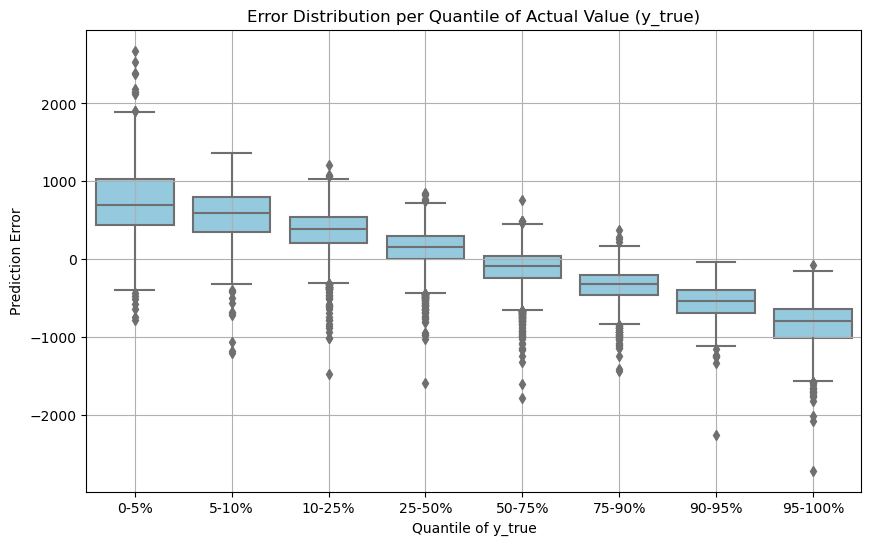

In [37]:
# Visualizing Error Distributions with the same color for all boxes
plt.figure(figsize=(10, 6))
sns.boxplot(x='Quantile Bin', y='error', data=predictions, color='skyblue')

plt.title('Error Distribution per Quantile of Actual Value (y_true)')
plt.xlabel('Quantile of y_true')
plt.ylabel('Prediction Error')
plt.grid(True)
plt.show()

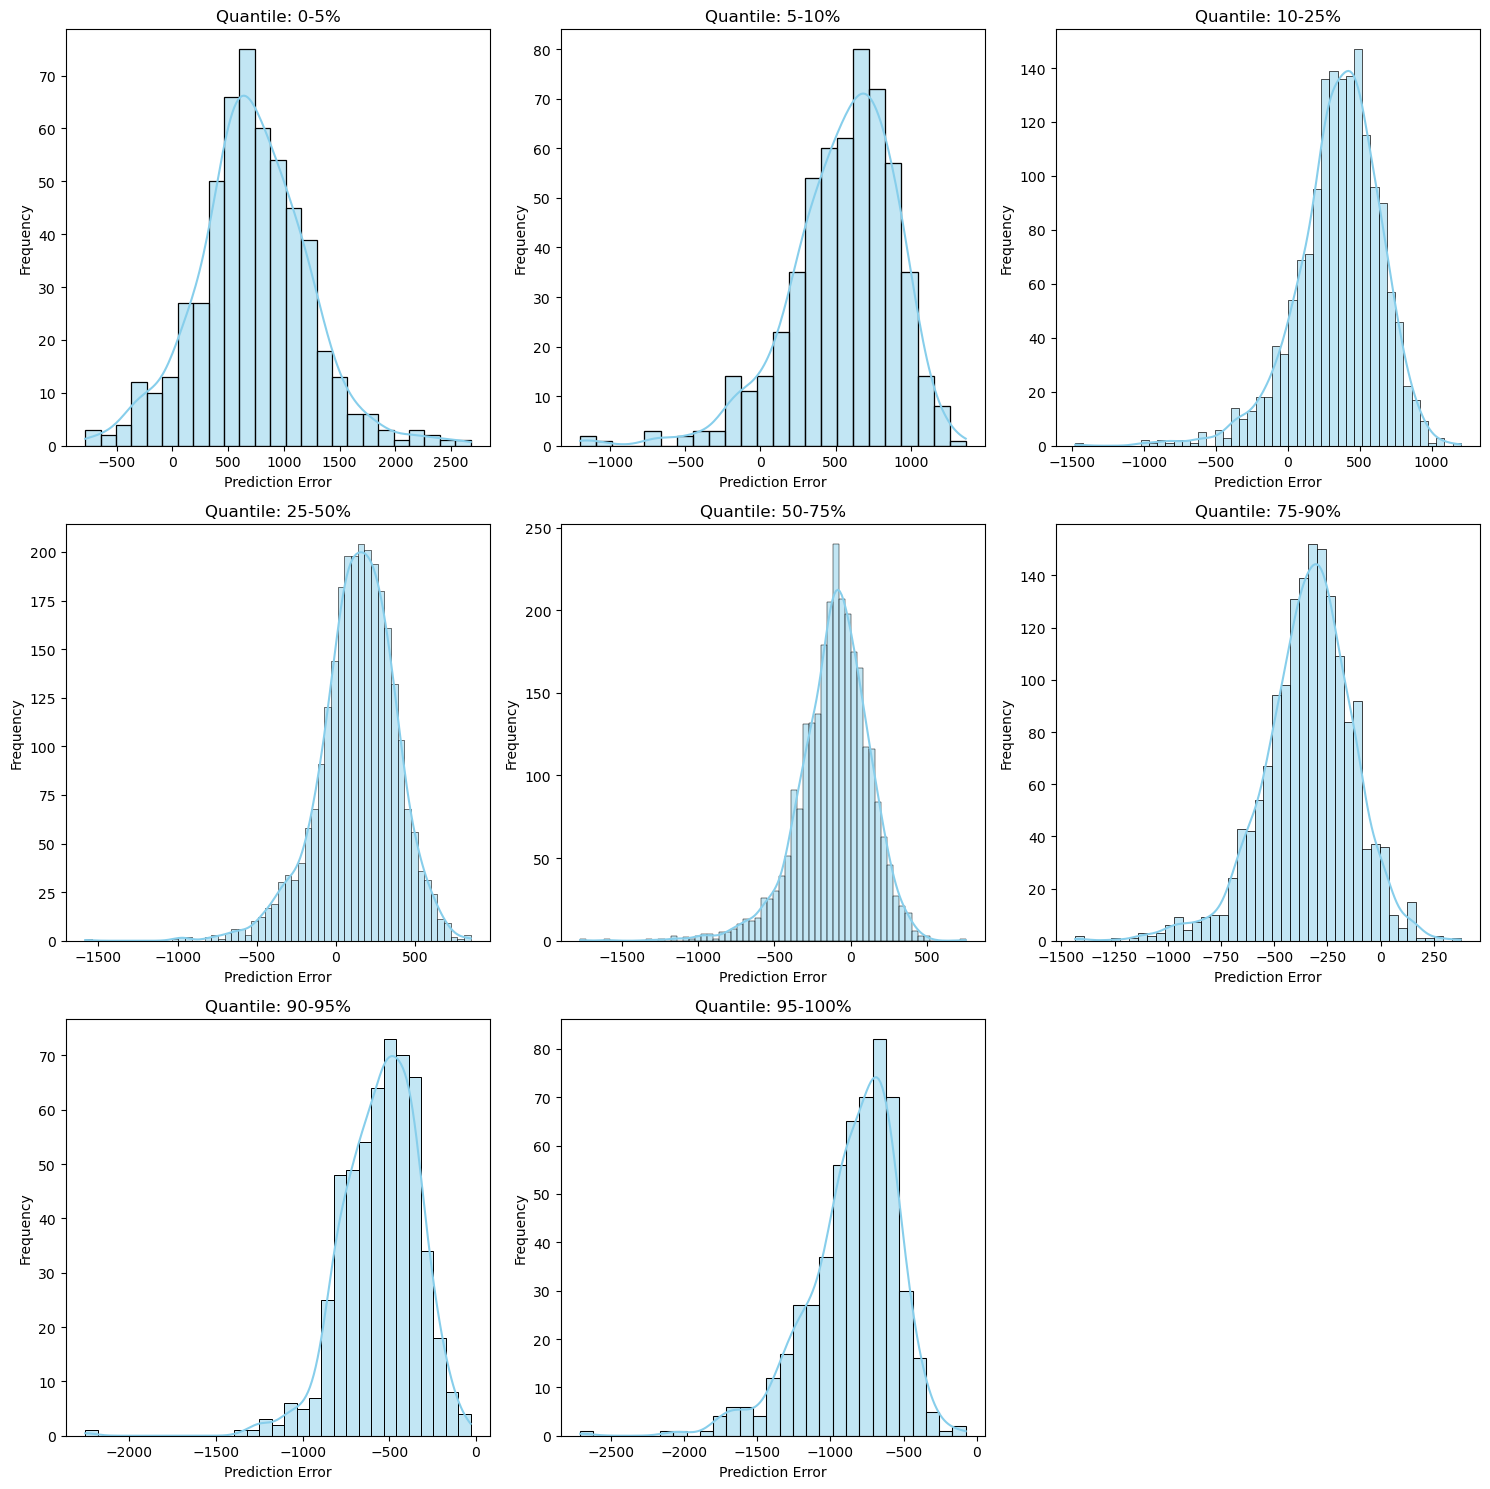

In [38]:
# Unique quantile bins, sorted
quantile_bins = predictions['Quantile Bin'].cat.categories

# Determine grid size for subplots: aiming for a roughly square arrangement
n_bins = len(quantile_bins)
grid_size = int(np.ceil(np.sqrt(n_bins)))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))

# Flatten axes array for easy iteration, in case of a 2D axes array
axes_flat = axes.flatten()

# Loop through each quantile bin and create a histogram in its subplot
for i, quantile in enumerate(quantile_bins):
    ax = axes_flat[i]
    subset = predictions[predictions['Quantile Bin'] == quantile]
    sns.histplot(subset['error'], ax=ax, color='skyblue', kde=True)
    ax.set_title(f'Quantile: {quantile}')
    ax.set_xlabel('Prediction Error')
    ax.set_ylabel('Frequency')

# Hide any unused subplot areas
for i in range(n_bins, len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.show()

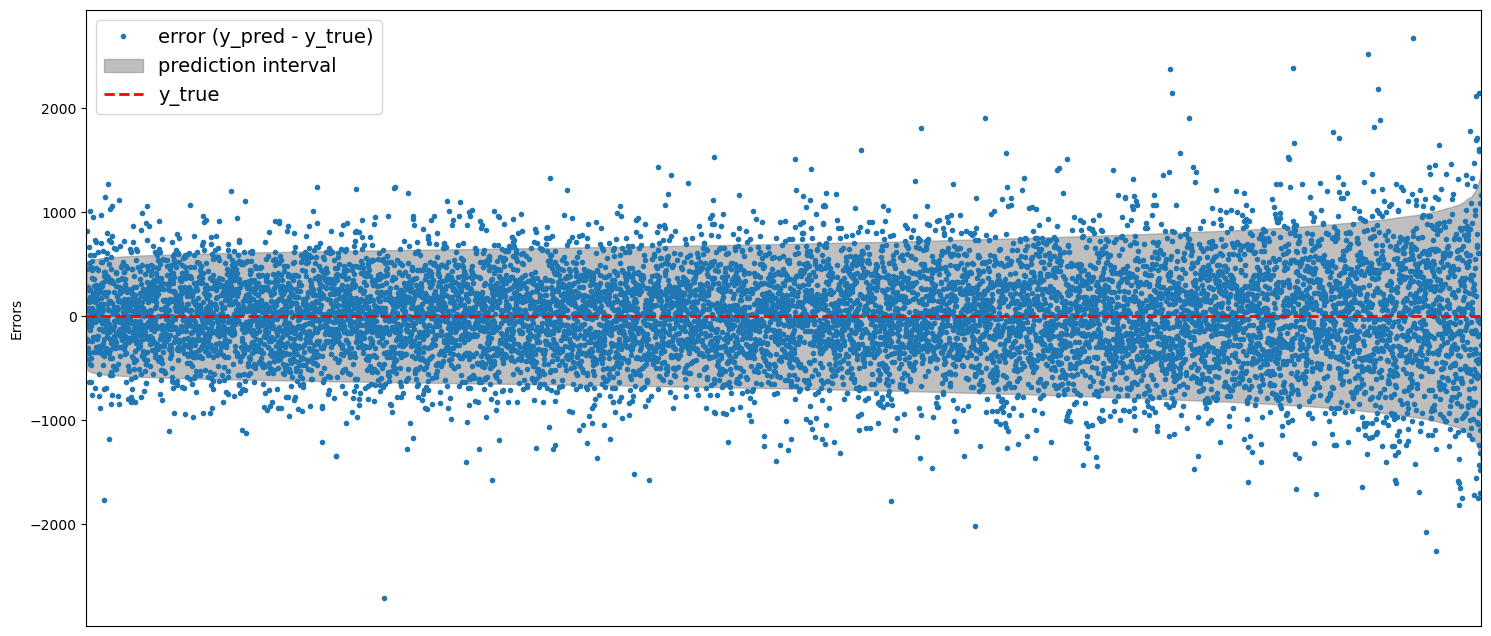

In [39]:
fig, ax = plt.subplots(figsize=(18, 8))

plt.plot(sorted_predictions["error"], 'o', markersize=3, label="error (y_pred - y_true)")

plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["error_lower"], 
                 sorted_predictions["error_upper"], 
                 alpha=0.5, color="grey", label="prediction interval")

ax.axline([0, 0], [1, 0], color = "red", linestyle='--', lw=2, zorder=3, label="y_true")
plt.xticks([])
plt.xlim([0, len(sorted_predictions)])
plt.ylabel("Errors")
plt.legend(loc="upper left", fontsize=14)
plt.show()

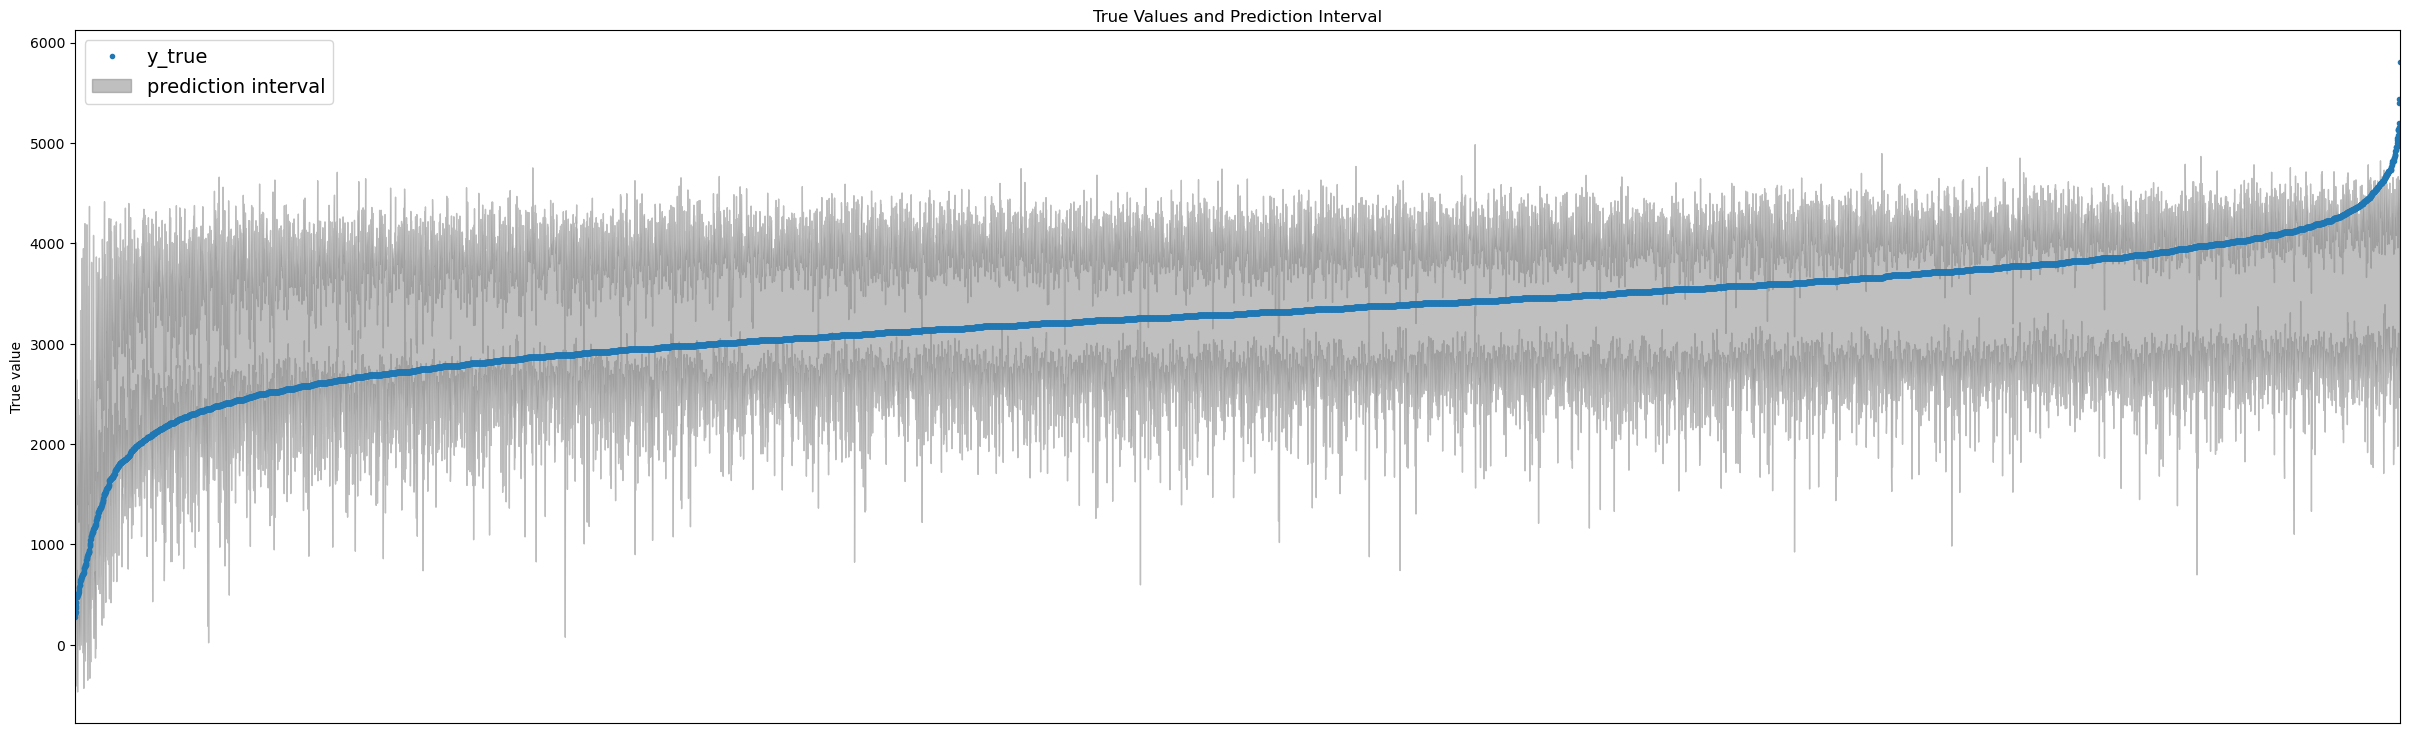

In [40]:
sorted_predictions = predictions.sort_values(by=['y_true']).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(30, 9))

plt.plot(sorted_predictions["y_true"], 'o', markersize=3, label="y_true")

plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["lower"], 
                 sorted_predictions["upper"], 
                 alpha=0.5, color="grey", label="prediction interval")

plt.xticks([])
plt.xlim([0, len(sorted_predictions)])
plt.ylabel("True value")
plt.legend(loc="upper left", fontsize=14)
plt.title('True Values and Prediction Interval')
plt.show()

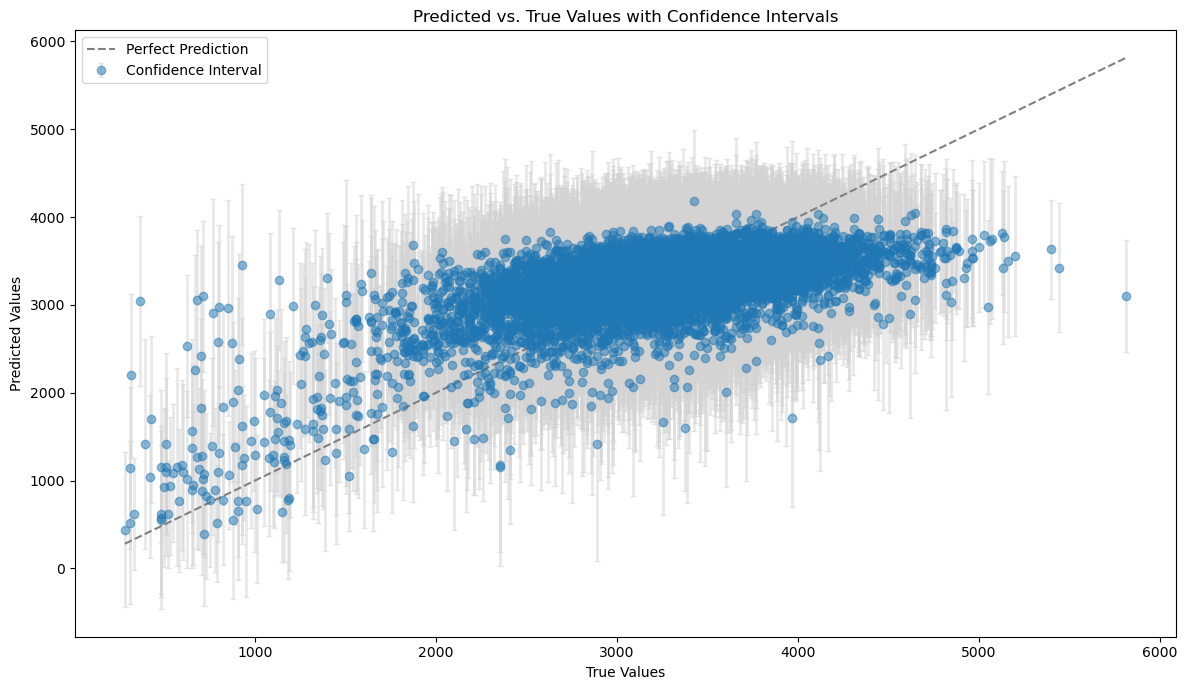

In [41]:
sorted_predictions = predictions.sort_values(by='y_true')

# Creating the plot
plt.figure(figsize=(12, 7))

# Calculating the ranges for the error bars (confidence intervals)
error_bars = [sorted_predictions['point prediction'] - sorted_predictions['lower'], 
              sorted_predictions['upper'] - sorted_predictions['point prediction']]

# Adding error bars to represent the confidence intervals
plt.errorbar(sorted_predictions['y_true'], 
             sorted_predictions['point prediction'], 
             yerr=error_bars, 
             fmt='o', ecolor='lightgray', 
             elinewidth=2, capsize=2, alpha=0.5, 
             label='Confidence Interval')

# Adding a diagonal line to indicate perfect predictions
plt.plot(sorted_predictions['y_true'], sorted_predictions['y_true'], color='grey', linestyle='--', label='Perfect Prediction')

# Adding labels, legend, and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values with Confidence Intervals')
plt.legend()
plt.tight_layout()
plt.show()

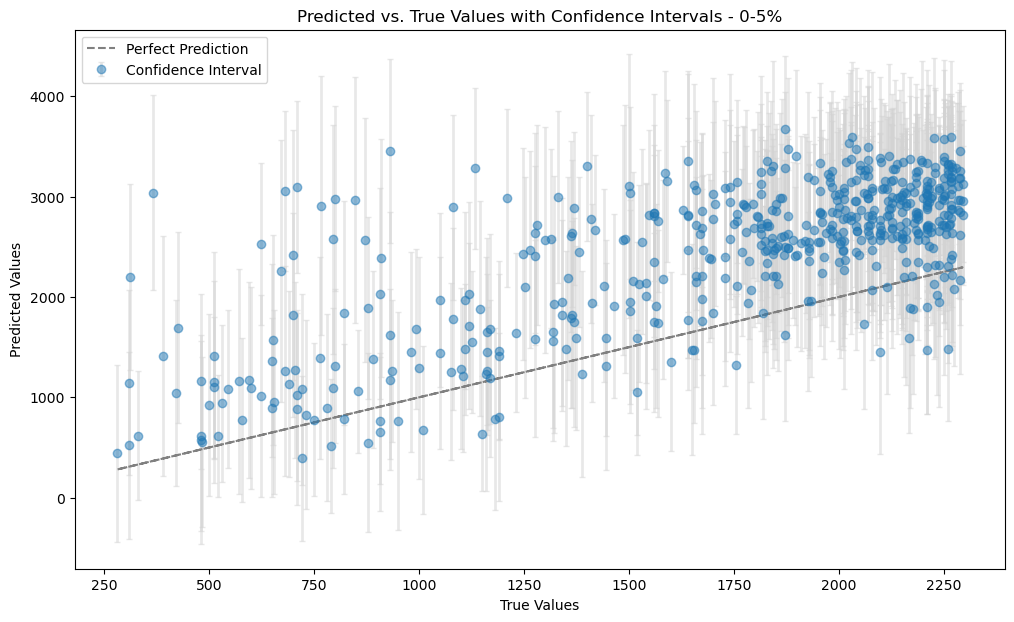

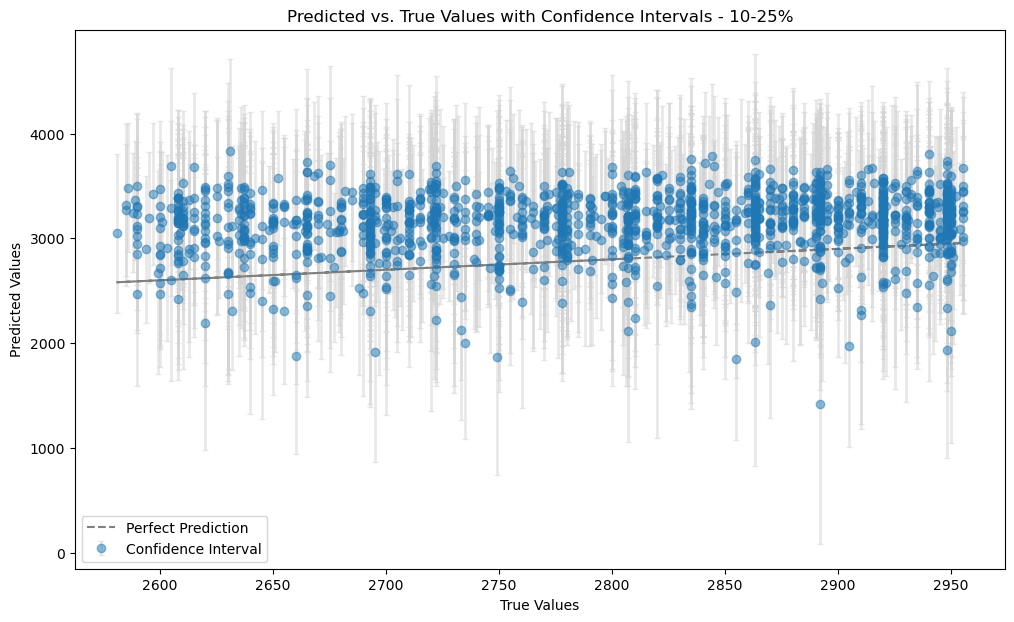

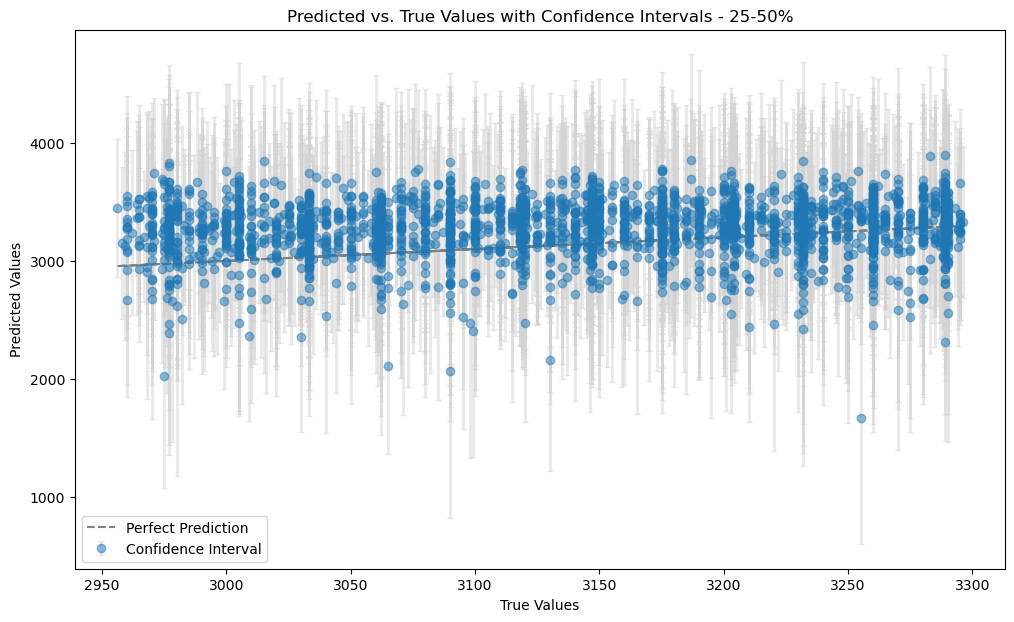

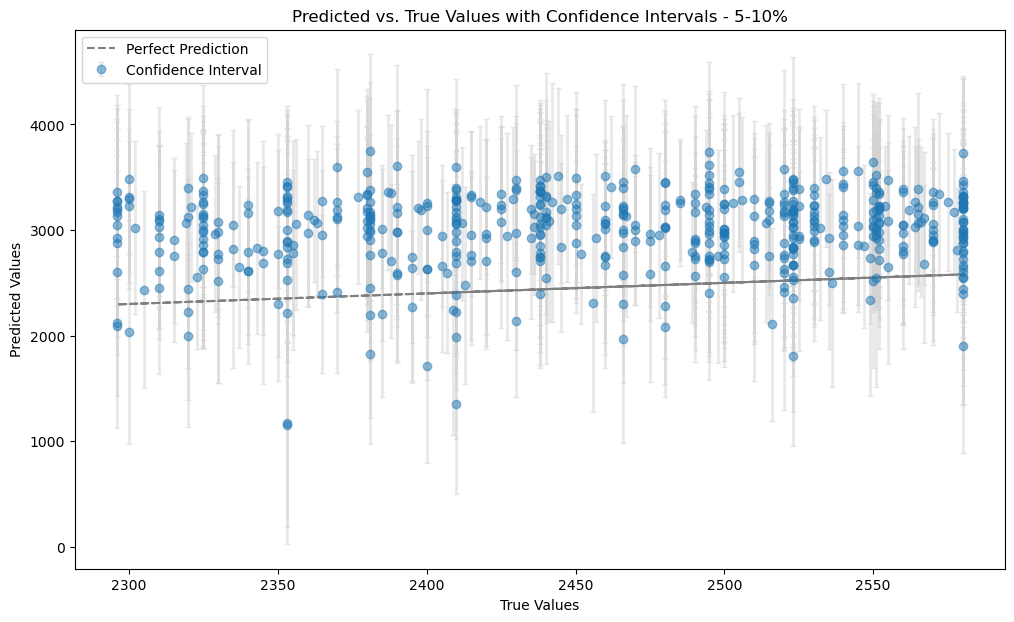

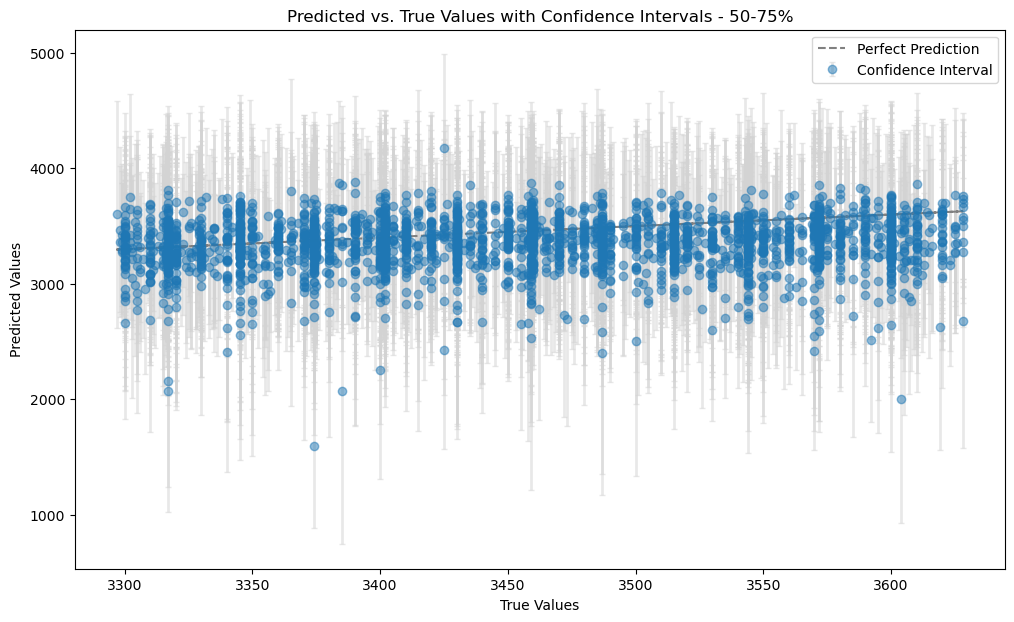

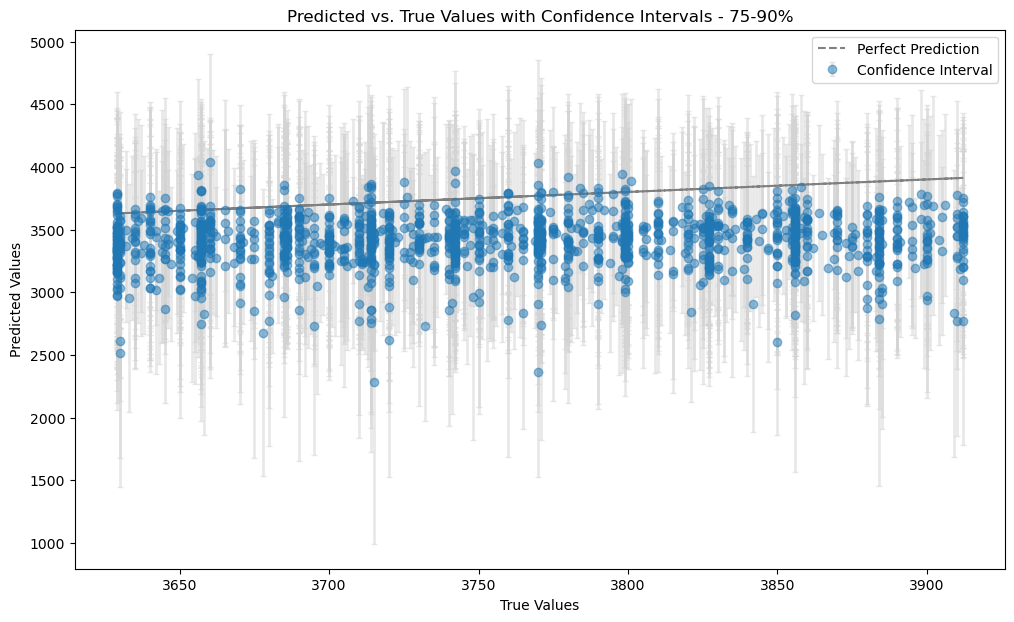

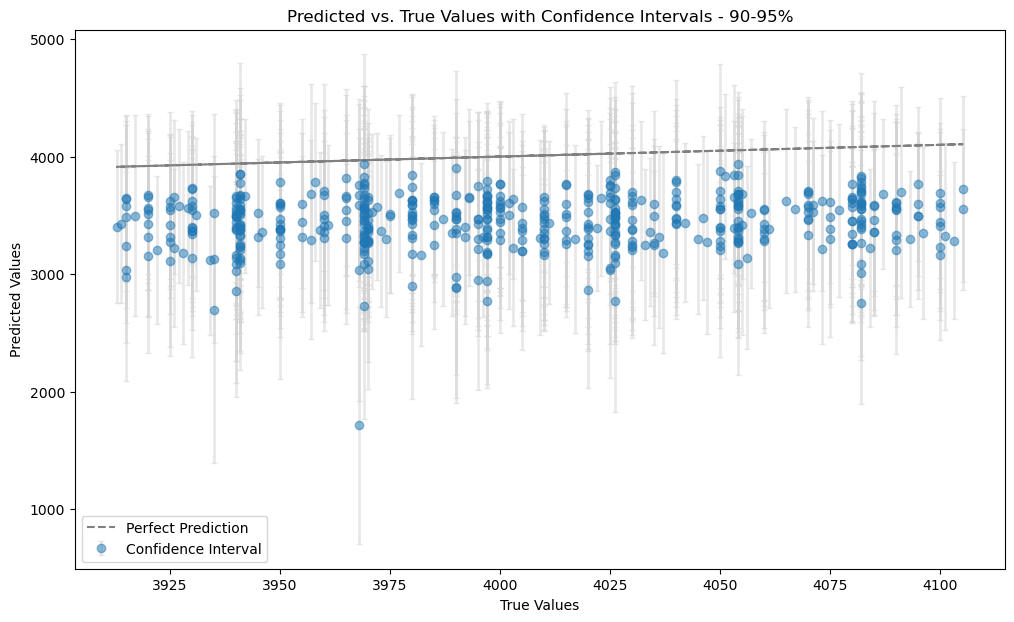

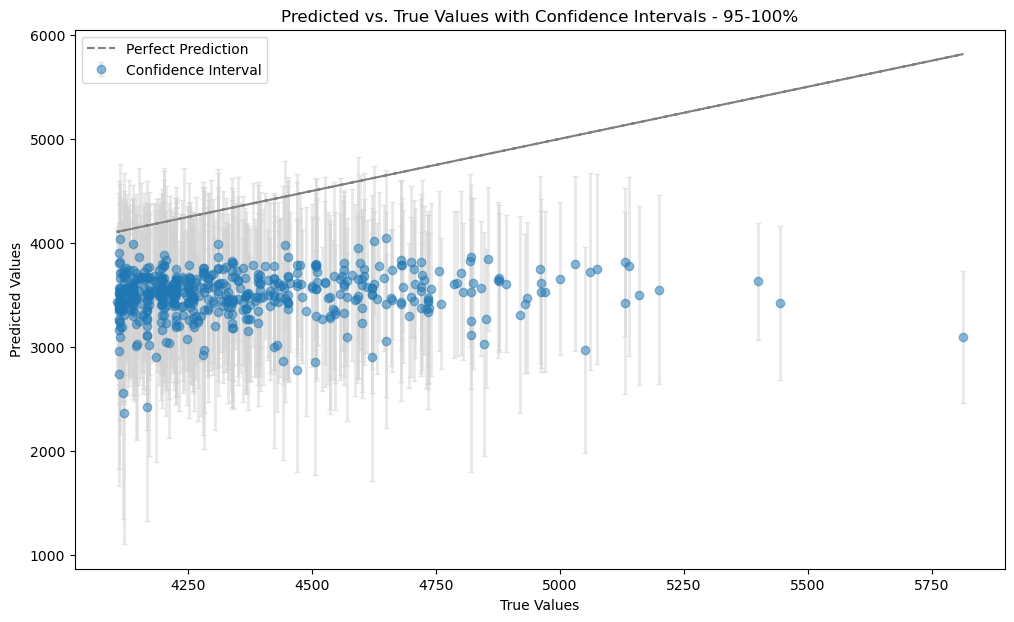

In [42]:
quantile_bins = sorted(predictions['Quantile Bin'].unique())

for quantile in quantile_bins:
    subset = predictions[predictions['Quantile Bin'] == quantile]
    
    # Setup figure
    plt.figure(figsize=(12, 7))
    
    # Calculating the ranges for the error bars (confidence intervals)
    error_bars = [subset['point prediction'] - subset['lower'], 
                  subset['upper'] - subset['point prediction']]
    
    # Scatter plot for predictions
    plt.errorbar(subset['y_true'], 
                 subset['point prediction'], 
                 yerr=error_bars, 
                 fmt='o', ecolor='lightgray', 
                 elinewidth=2, capsize=2, alpha=0.5, 
                 label='Confidence Interval')
    
    # Adding a diagonal line to indicate perfect predictions
    plt.plot(subset['y_true'], subset['y_true'], color='grey', linestyle='--', label='Perfect Prediction')
    
    # Adding titles and labels
    plt.title(f'Predicted vs. True Values with Confidence Intervals - {quantile}')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()

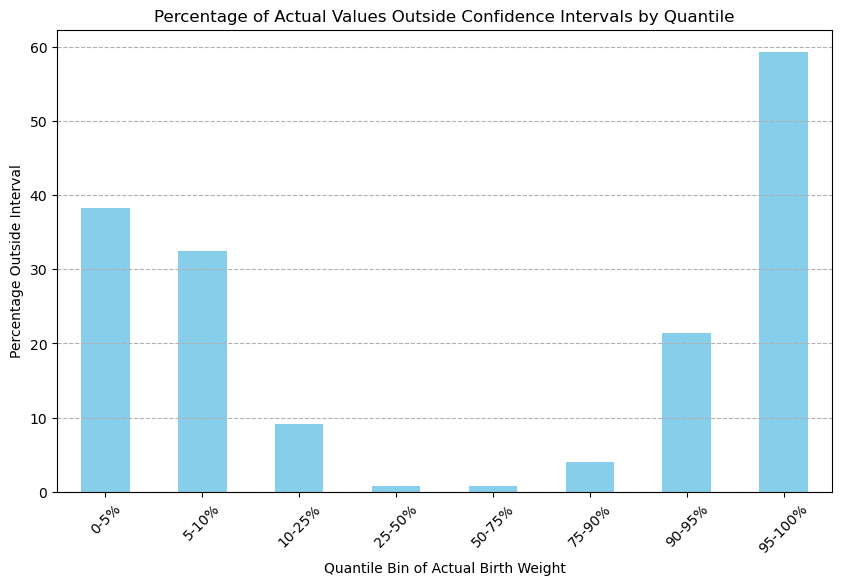

In [43]:
# Calculate the Percentage of `y_true` Outside the Interval for Each Quantile Bin
quantile_outside_percent = predictions.groupby('Quantile Bin')['Inside Interval'].apply(lambda x: (1 - x.mean()) * 100)

# Creating the bar chart
plt.figure(figsize=(10, 6))
quantile_outside_percent.plot(kind='bar', color='skyblue')

plt.title('Percentage of Actual Values Outside Confidence Intervals by Quantile')
plt.xlabel('Quantile Bin of Actual Birth Weight')
plt.ylabel('Percentage Outside Interval')
plt.xticks(rotation=45)

plt.grid(axis='y', linestyle='--')
plt.show()

In [44]:
MWIS,coverage = MWIS_metric.score(predictions["y_true"],predictions["lower"],predictions["upper"],alpha)
print(f"MWI score          ",round(MWIS,3))
print("Predictions coverage   ", round(coverage*100,1),"%")

MWI score           1904.265
Predictions coverage    90.0 %


In [45]:
# todo check (negatives

# Reproduce & submit

In [46]:
conservativity = 0.005
alpha_test = 0.10 - conservativity
pred_test = model.predict(test_processed)

In [47]:
y_pred_norm_test = pred_test[:, 0].reshape(-1, 1) + np.array([[-1, 1]]) * (cal_scores_norm[int(np.floor(len(cal_scores_norm)*alpha_test))] * np.sqrt(pred_test[:, 1])).reshape(-1, 1)
y_pred_norm_test.clip(y_train.min(), y_train.max())
# todo test without min/max)

array([[2597.93421388, 4334.28665864],
       [2507.29198665, 3714.07644595],
       [2555.39183043, 3798.80545561],
       ...,
       [2758.72219445, 4235.84747909],
       [2701.95124675, 4065.37127109],
       [2719.89067587, 4530.20760493]])

In [48]:
sample_submission = pd.read_csv(submission_path)
sample_submission["pi_lower"] = y_pred_norm_test[:, 0]
sample_submission["pi_upper"] = y_pred_norm_test[:, 1]
sample_submission.to_csv('submission.csv',index=False)